In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import RMSE_denormalised_P, RMSE_denormalised_T, RMSE_denormalised_temperature_only
from ml_tb.validation import load_k_models, predict_on_val_set
from ml_tb.plot import zone_to_number, plot_sequence_locality

In [2]:
MOLAR_WEIGHTS = {"SiO2": 60.08,
                 "TiO2": 79.87,
                 "Al2O3": 101.96,
                 "FeO": 71.84,
                 "MnO": 70.94,
                 "MgO": 40.30,
                 "CaO": 56.08,
                 "Na2O": 61.98,
                 "K2O": 94.20}

MOLAR_WEIGHTS = pd.DataFrame(MOLAR_WEIGHTS, index=[0])

CATION_NUMBERS = {"SiO2": 1,
                  "TiO2": 1,
                  "Al2O3": 2,
                  "FeO": 1,
                  "MnO": 1,
                  "MgO": 1,
                  "CaO": 1,
                  "Na2O": 2,
                  "K2O": 2}

CATION_NUMBERS = pd.DataFrame(CATION_NUMBERS, index=[0])

OXYGEN_NUMBERS = {"SiO2": 2,
                  "TiO2": 2,
                  "Al2O3": 3,
                  "FeO": 1,
                  "MnO": 1,
                  "MgO": 1,
                  "CaO": 1,
                  "Na2O": 1,
                  "K2O": 1}

OXYGEN_NUMBERS = pd.DataFrame(OXYGEN_NUMBERS, index=[0])

def calculate_element_apfu(biotite_composition_wt, ox_base=11, molar_weights=MOLAR_WEIGHTS, cation_numbers=CATION_NUMBERS, oxygen_numbers=OXYGEN_NUMBERS):
    # divide bioite composition by corresponding molar weight, by maching the column names. Apply to all rows
    biotite_composition_mol = biotite_composition_wt.div(molar_weights.iloc[0], axis=1)
    biotite_composition_cations = biotite_composition_mol.mul(cation_numbers.iloc[0], axis=1)
    biotite_composition_oxygens = biotite_composition_mol.mul(oxygen_numbers.iloc[0], axis=1)

    # sum the oxygen numbers
    biotite_composition_oxygens["O"] = biotite_composition_oxygens.sum(axis=1)
    # normalize the cations, to a total of 11 oxygens (set in ox_base)
    biotite_composition_cations_normalized = biotite_composition_cations.div(biotite_composition_oxygens["O"], axis=0) * ox_base

    # rename and reorder the columns to [Si, Ti, Al, Fe, Mn, Mg, Ca, Na, K, Total]
    biotite_composition_cations_normalized.columns = ["Al", "Ca", "Fe", "K", "Mg", "Mn", "Na", "Si", "Ti", "Total"]
    biotite_composition_cations_normalized = biotite_composition_cations_normalized[["Si", "Ti", "Al", "Fe", "Mn", "Mg", "Ca", "Na", "K", "Total"]]

    return biotite_composition_cations_normalized

In [3]:
biotite_composition_wt = pd.read_excel(Path("biotite_comp_Yogi_et_al_2024_JMG_SupplMat2_28HF18.xlsx"))

biotite_composition_cations_normalized = calculate_element_apfu(biotite_composition_wt)

In [4]:
bt_val_data_Yogi = biotite_composition_cations_normalized[["Si", "Ti", "Al", "Fe", "Mn", "Mg"]].to_numpy()

In [5]:
# define the custom metrics
scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)

def RMSE_P(y_true, y_pred):
    return RMSE_denormalised_P(y_true, y_pred, inv_scaling_pt)

def RMSE_T(y_true, y_pred):
    return RMSE_denormalised_T(y_true, y_pred, inv_scaling_pt)

In [6]:
models_MnFMAST = load_k_models("AA_k_MnFMAST", Path("01_fit_natural_biotite", "saved_models"), [RMSE_T, RMSE_P])

models_ds62 = load_k_models("model_ds62White2014", Path("02_pretraining", "saved_models"), [RMSE_T, RMSE_P], k_models=False)
models_ds55Bt07 = load_k_models("model_ds55White2007", Path("02_pretraining", "saved_models"), [RMSE_T, RMSE_P], k_models=False)
models_ds55BtT = load_k_models("model_ds55Tajcmanova2009", Path("02_pretraining", "saved_models"), [RMSE_T, RMSE_P], k_models=False)

models_transfers_ds62 = load_k_models("k_ds62", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])
models_transfers_ds55Bt07 = load_k_models("k_ds55Bt07", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])
models_transfers_ds55BtT = load_k_models("k_ds55BtT", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])

In [7]:
def predict_with_k_models(data, k_models, inv_scaling_pt):
    preds = []

    for model in k_models:
        preds.append(inv_scaling_pt(model(data)))

    return np.array(preds)

In [8]:
preds_MnFMAST = predict_with_k_models(bt_val_data_Yogi, models_MnFMAST, inv_scaling_pt)

preds_ds62 = predict_with_k_models(bt_val_data_Yogi, models_ds62, inv_scaling_pt)
preds_ds55Bt07 = predict_with_k_models(bt_val_data_Yogi, models_ds55Bt07, inv_scaling_pt)
preds_ds55BtT = predict_with_k_models(bt_val_data_Yogi, models_ds55BtT, inv_scaling_pt)

preds_transfers_ds62 = predict_with_k_models(bt_val_data_Yogi, models_transfers_ds62, inv_scaling_pt)
preds_transfers_ds55Bt07 = predict_with_k_models(bt_val_data_Yogi, models_transfers_ds55Bt07, inv_scaling_pt)
preds_transfers_ds55BtT = predict_with_k_models(bt_val_data_Yogi, models_transfers_ds55BtT, inv_scaling_pt)

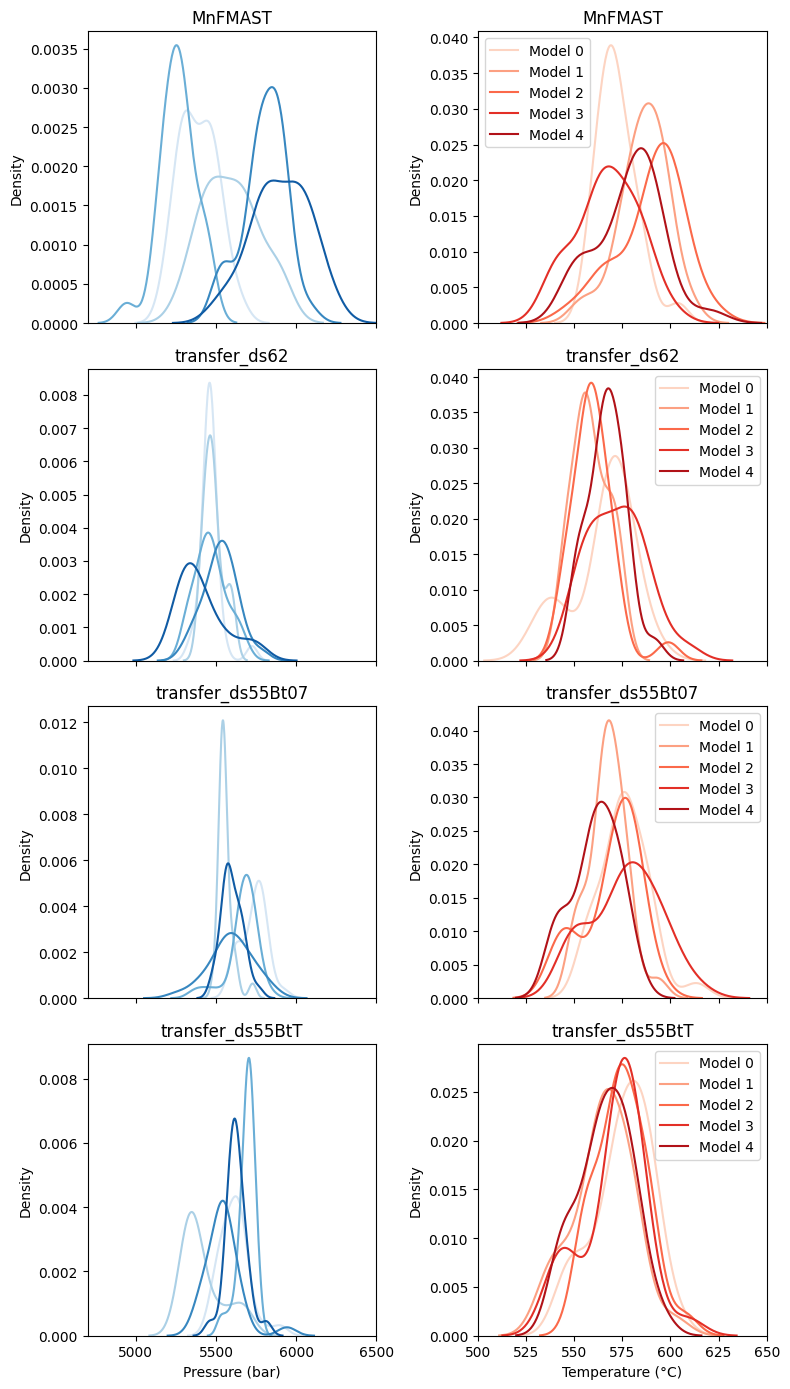

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(8, 14), sharex="col")

for i, preds, title in zip(range(4),
                           [preds_MnFMAST, preds_transfers_ds62, preds_transfers_ds55Bt07, preds_transfers_ds55BtT],
                           ["MnFMAST", "transfer_ds62", "transfer_ds55Bt07", "transfer_ds55BtT"]):

    for j, c in zip(range(preds.shape[0]), sns.color_palette("Blues", 5)):
        sns.kdeplot(preds[j, :, 0], ax=axs[i, 0], label=f"Model {j}", color=c)

    axs[i, 0].set_xlabel("Pressure (bar)")
    axs[i, 0].set_ylabel("Density")
    axs[i, 0].set_xlim(4700, 6500)

    axs[i, 0].set_title(title)

    for j, c in zip(range(preds.shape[0]), sns.color_palette("Reds", 5)):
        sns.kdeplot(preds[j, :, 1], ax=axs[i, 1], label=f"Model {j}", color=c)

    axs[i, 1].set_xlabel("Temperature (°C)")
    axs[i, 1].set_ylabel("Density")
    axs[i, 1].set_xlim(500, 650)

    axs[i, 1].set_title(title)
    axs[i, 1].legend()

fig.tight_layout()
# fig.savefig(Path("exported_figs_errorprop", "error_prop_measurements_Yogi2024.pdf"), dpi=600)

In [10]:
rangen = np.random.default_rng(42)

def sim_measurement_error_MC(analysis, n_samples=1000, rel_error=0.01):
    analysis = analysis.to_numpy()[0]
    error = rangen.normal(0, rel_error, size=(n_samples, analysis.shape[0]))
    return analysis + analysis * error

In [11]:
bt_single_analysis = biotite_composition_wt.iloc[[0]]
# set Mn to 0.01 instead of 0.00
bt_single_analysis["MnO"] = 0.01

# set element specific errors: 	SiO2 TiO2 Al2O3 FeO MnO MgO CaO Na2O K2O Total
element_errors = [0.01, 0.01, 0.01, 0.01, 0.1, 0.01, 0.01, 0.1, 0.1, 0.00]

bt_analysis_MC = sim_measurement_error_MC(bt_single_analysis, rel_error=element_errors)

bt_single_analysis = calculate_element_apfu(pd.DataFrame(bt_single_analysis, columns=biotite_composition_wt.columns))
bt_analysis_MC = calculate_element_apfu(pd.DataFrame(bt_analysis_MC, columns=biotite_composition_wt.columns))

bt_single_analysis = bt_single_analysis[["Si", "Ti", "Al", "Fe", "Mn", "Mg"]].to_numpy()
bt_analysis_MC = bt_analysis_MC[["Si", "Ti", "Al", "Fe", "Mn", "Mg"]].to_numpy()

/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_38943/2404020576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt_single_analysis["MnO"] = 0.01


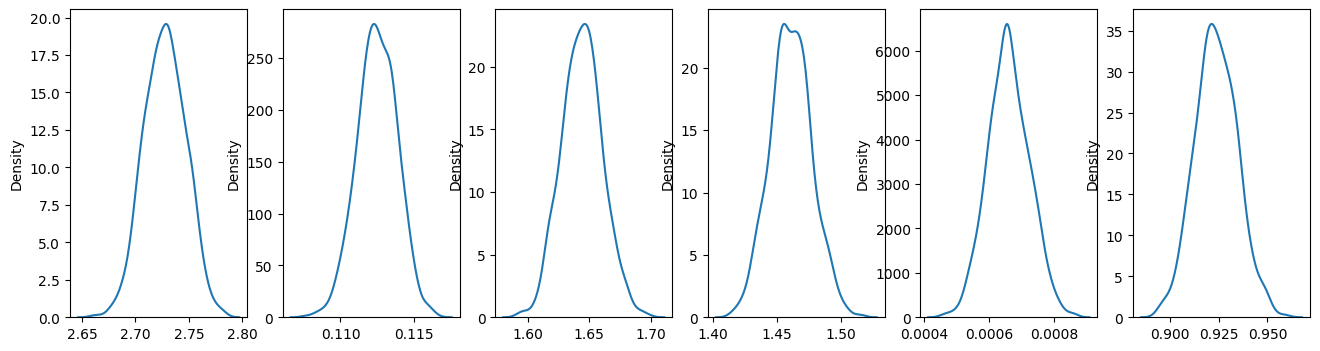

In [12]:
# plot bt_analysis_MC, to check if distribution is reasonable
fig, axs = plt.subplots(1, 6, figsize=(16, 4))

for i in range(bt_analysis_MC.shape[1]):
    sns.kdeplot(bt_analysis_MC[:, i], ax=axs[i])

In [13]:
preds_single_analysis_MnFMAST = predict_with_k_models(bt_single_analysis, models_MnFMAST, inv_scaling_pt)

preds_single_analysis_ds62 = predict_with_k_models(bt_single_analysis, models_ds62, inv_scaling_pt)
preds_single_analysis_ds55Bt07 = predict_with_k_models(bt_single_analysis, models_ds55Bt07, inv_scaling_pt)
preds_single_analysis_ds55BtT = predict_with_k_models(bt_single_analysis, models_ds55BtT, inv_scaling_pt)

preds_single_analysis_transfers_ds62 = predict_with_k_models(bt_single_analysis, models_transfers_ds62, inv_scaling_pt)
preds_single_analysis_transfers_ds55Bt07 = predict_with_k_models(bt_single_analysis, models_transfers_ds55Bt07, inv_scaling_pt)
preds_single_analysis_transfers_ds55BtT = predict_with_k_models(bt_single_analysis, models_transfers_ds55BtT, inv_scaling_pt)


preds_analysisMC_MnFMAST = predict_with_k_models(bt_analysis_MC, models_MnFMAST, inv_scaling_pt)

preds_analysisMC_ds62 = predict_with_k_models(bt_analysis_MC, models_ds62, inv_scaling_pt)
preds_analysisMC_ds55Bt07 = predict_with_k_models(bt_analysis_MC, models_ds55Bt07, inv_scaling_pt)
preds_analysisMC_ds55BtT = predict_with_k_models(bt_analysis_MC, models_ds55BtT, inv_scaling_pt)

preds_analysisMC_transfers_ds62 = predict_with_k_models(bt_analysis_MC, models_transfers_ds62, inv_scaling_pt)
preds_analysisMC_transfers_ds55Bt07 = predict_with_k_models(bt_analysis_MC, models_transfers_ds55Bt07, inv_scaling_pt)
preds_analysisMC_transfers_ds55BtT = predict_with_k_models(bt_analysis_MC, models_transfers_ds55BtT, inv_scaling_pt)

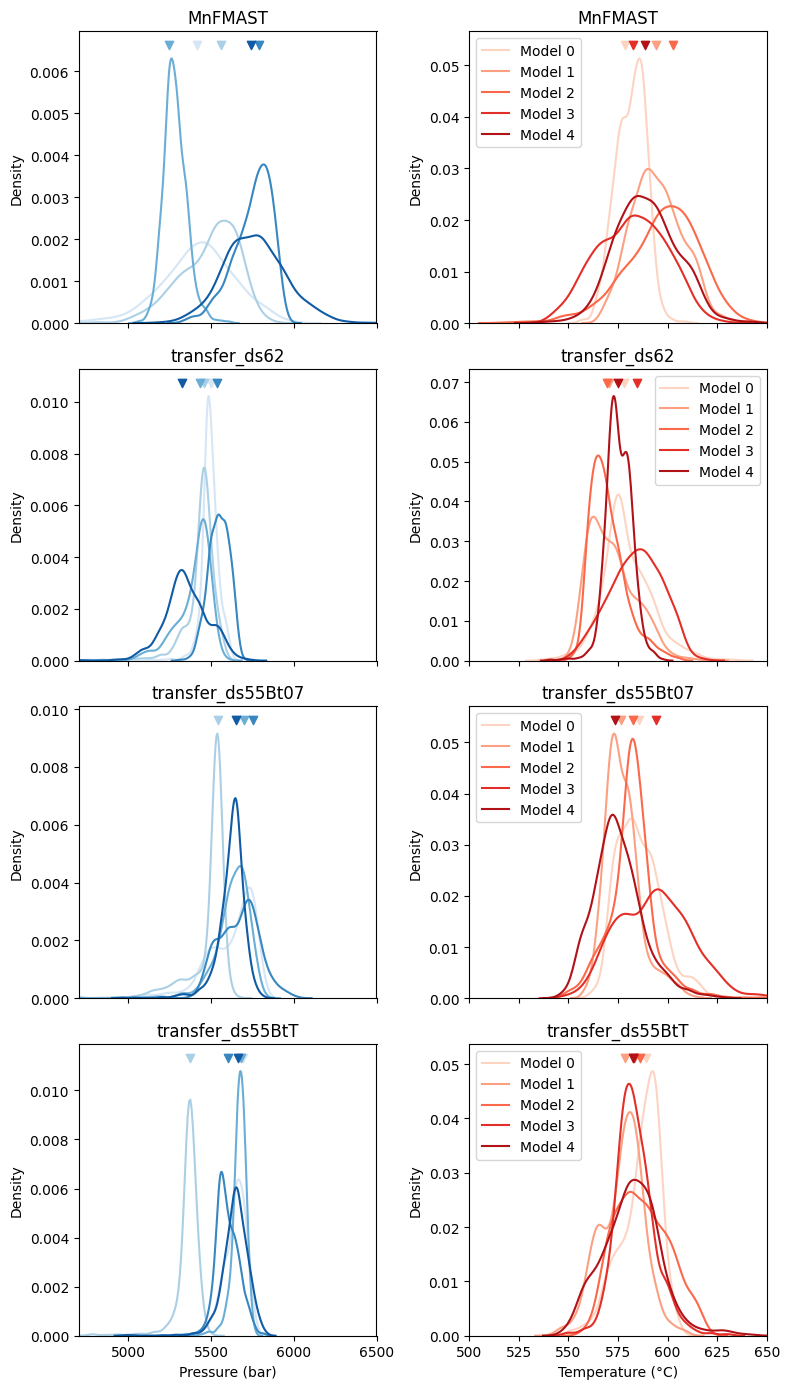

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(8, 14), sharex="col")

for i, preds_single, preds_MC, title in zip(range(4),
                           [preds_single_analysis_MnFMAST, preds_single_analysis_transfers_ds62, preds_single_analysis_transfers_ds55Bt07, preds_single_analysis_transfers_ds55BtT],
                           [preds_analysisMC_MnFMAST, preds_analysisMC_transfers_ds62, preds_analysisMC_transfers_ds55Bt07, preds_analysisMC_transfers_ds55BtT],
                           ["MnFMAST", "transfer_ds62", "transfer_ds55Bt07", "transfer_ds55BtT"]):

    for j, c in zip(range(preds_MC.shape[0]), sns.color_palette("Blues", 5)):
        sns.kdeplot(preds_MC[j, :, 0], ax=axs[i, 0], label=f"Model {j}", color=c)

    ylim = axs[i, 0].get_ylim()

    for j, c in zip(range(preds_single.shape[0]), sns.color_palette("Blues", 5)):
        axs[i, 0].scatter(preds_single[j, 0, 0], ylim[1], marker="v", color=c)

    axs[i, 0].set_xlabel("Pressure (bar)")
    axs[i, 0].set_ylabel("Density")
    axs[i, 0].set_xlim(4700, 6500)

    axs[i, 0].set_title(title)

    for j, c in zip(range(preds_MC.shape[0]), sns.color_palette("Reds", 5)):
        sns.kdeplot(preds_MC[j, :, 1], ax=axs[i, 1], label=f"Model {j}", color=c)

    ylim = axs[i, 1].get_ylim()

    for j, c in zip(range(preds_single.shape[0]), sns.color_palette("Reds", 5)):
        axs[i, 1].scatter(preds_single[j, 0, 1], ylim[1], marker="v", color=c)

    axs[i, 1].set_xlabel("Temperature (°C)")
    axs[i, 1].set_ylabel("Density")
    axs[i, 1].set_xlim(500, 650)

    axs[i, 1].set_title(title)
    axs[i, 1].legend()

fig.tight_layout()
# fig.savefig(Path("exported_figs_errorprop", "error_prop_MCsim.pdf"), dpi=600)